# Исследование рисков болезней сердца


## Введение

Сегодня мы будем работать с датасетом, известным, как Heart Disease Data Set. Он предоставлен Венгерским институтом кардиографии, расположенном в Будапеште. В нём содержатся анонимные медицинские данные о 303 пациентах, больных, либо не больных сердечными заболеваниями. В качестве признаков там представлены:

1. `age` - возраст
2. `sex` - пол
3. `cp` - "chest pain type" - тип боли в груди. Категориальный признак, возможны значения 0, 1, 2, 3
4. `trestbps` - "resting blood pressure" - артериальное давление в покое
5. `chol` - "serum cholestoral in mg/dl" - уровень холестерина в мг/дл
6. `fbs` - "fasting blood sugar > 120 mg/dl" - превосходит ли уровень сахара в крови натощак значение 120 мг/дл
7. `restecg` - "resting electrocardiographic results" - результаты электрокардиографии в покое. Категориальный презнак, значения 0, 1, 2
8. `thalach` - максимальный пульс
9. `exang` - "exercise induced angina" - возникает ли стенокардия при физической нагрузке
10. `oldpeak` - "ST depression induced by exercise relative to rest" - Уменьшение ST-интервала, на кардиограмме при физической нагрузке по сравнению с покоем. Значения 0, 1, 2
11. `slope` - "the slope of the peak exercise ST segment" - крутость ST-интервала при нагрузке
12. `ca` - "number of major vessels colored by flourosopy" - количество крупных сосудов, окрашенных при флюорографии (??), значения 0, 1, 2, 3
13. `thal` - некий категориальные параметр, относящися к талассеми́и (анемии Кули) - заболеванию, в основе которого лежит снижение синтеза полипептидных цепей, входящих в структуру нормального гемоглобина, сообщает нам Капитан Вкипедия. Значения 0, 1, 2, 3
14. `target` - целевой признак, который показывает наличие сердечного заболевания. В данном случае тип заболевания не специфицирован, рассматривается только его наличие 1, либо отсутствие 0

## Загрузка данных

Для начала, импортируем необходимые модули. Для удобства экспериментирования, возьмём "с запасом":

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
import matplotlib.pyplot as plt

Для нормализации данных нам понадобится готовый класс `StandardScaler`:

In [2]:
from sklearn.preprocessing import StandardScaler

Загрузим датасет и немного посмотрим на него:

In [3]:
data_frame = pd.read_csv("heart.csv")
data_frame

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Обратите внимание, что по целевому признаку сначала идут больные, а затем - здоровые. 

## Визуализация данных

Сегодня мы попробуем "посмотреть" на данные, визуализировать их. Для этого нам понадобится отдельно иметь набор больных и набор здоровых:

In [4]:
positive = data_frame[data_frame["target"] == 1]
negative = data_frame[data_frame["target"] == 0]

Выберем признаки, на которые мы будем "смотреть", и построим для каждой пары признаков график, на котором отметим больных и здоровых разным цветом.

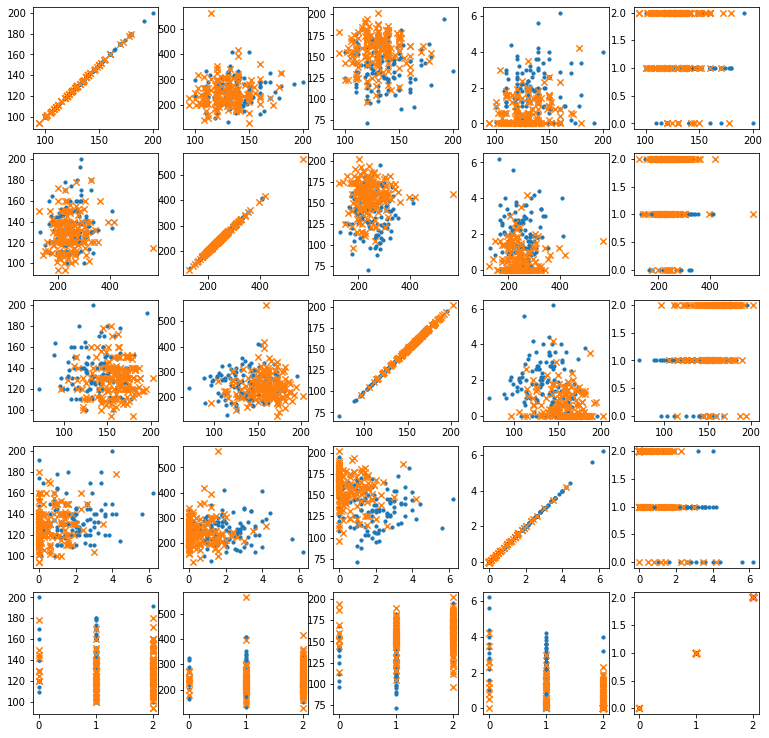

In [29]:
features_to_plot_scatter = ["trestbps", "chol", "thalach", "oldpeak", "slope"]

features_to_plot_count = len(features_to_plot_scatter)

fig, axs = plt.subplots(features_to_plot_count, features_to_plot_count, figsize=(13, 13))
for i in range(features_to_plot_count):
    for j in range(features_to_plot_count):
        axs[i, j].scatter(negative[features_to_plot_scatter[i]], negative[features_to_plot_scatter[j]], s=10, marker='o')
        axs[i, j].scatter(positive[features_to_plot_scatter[i]], positive[features_to_plot_scatter[j]], s=40, marker='x')

Данные графики позволяют предварительно оценить разделимость данных. Как видно, никакие два признака не позволяют нам задёшево провести разделительную прямую. Однако могут натолкнуть нас на некоторые идеи из feature engineering - модификации и комбинации признаков для улучшения их разделимости.

## Классификация

Теперь, преобразуем неупорядоченные категориальные признаки в бинарные. Тип боли в груди и показатель `thal` являются неупорядоченными, таким образом добавим следующие поля:

In [6]:
data_frame["cp_0"] = data_frame["cp"] == 0
data_frame["cp_1"] = data_frame["cp"] == 1
data_frame["cp_2"] = data_frame["cp"] == 2
data_frame["cp_3"] = data_frame["cp"] == 3

data_frame["thal_0"] = data_frame["thal"] == 0
data_frame["thal_1"] = data_frame["thal"] == 1
data_frame["thal_2"] = data_frame["thal"] == 2
data_frame["thal_3"] = data_frame["thal"] == 3

Удалим поля `cp` и `thal` и рандомизируем датасет:

In [7]:
data_frame = data_frame.drop(columns=["cp", "thal"])
data_frame = data_frame.sample(frac=1, random_state=1234).dropna()

Разделим на обучающию и вализационную выборки:

In [8]:
train_part = 0.8
train_size = int(len(data_frame) * train_part)

train_set = data_frame.iloc[:train_size, :]
val_set = data_frame.iloc[train_size:, :]

train_y = train_set["target"].values
train_X = train_set.drop(columns=["target"]).values

val_y = val_set["target"].values
val_X = val_set.drop(columns=["target"]).values

Теперь, нам нужно нормализовать данные. Для этого существует класс `StandardScaler`. У него есть два метода, нужных нам: `fit` и `transform`. Метод `fit` принимает матрицу признаков и вычисляет по ней средние и стандартные отклонения, и запоминает. Теперь метод `transform` может выполнить нормализющее преобразование данных. Чтобы было честно, мы вызываем метод `fit` только на обучающем датасете.

In [9]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

Создадим классификатор и обучим его. В закомментированном коде есть альтернативные классификаторы:

In [10]:
# Решающее дерево
# clf = DecisionTreeClassifier(random_state=1234)

# Метод k ближайших соседей
# clf = KNeighborsClassifier(n_neighbors=3)

# Случайный лес
# clf = RandomForestClassifier()

# Логистическая регрессия
clf = LogisticRegression()

# Перцептрон - простейшая нейронная сеть
# clf = Perceptron(penalty="l2", alpha=0.0003, tol=1e-4, random_state=1234)

# Многослойная нейронная сеть
# clf = MLPClassifier(solver='adam', alpha=1e-4,
#                       hidden_layer_sizes=(10, 10, 10, 10), random_state=0, max_iter=1000)

# Метод опорных векторов
# clf = SVC()

clf.fit(train_X, train_y)

LogisticRegression()

Теперь, классификатор можно провалидировать. Но перед тем, как подать валидационную выборку  в функцию `predict`, её нужно точно так же нормировать, как и обучающую:

In [11]:
val_X = scaler.transform(val_X)
predicted_y = clf.predict(val_X)

Предсказания готовы, можно посчитать метрики и построить `confusion matrix`:

In [12]:
print(classification_report(val_y, predicted_y))
print(sklearn.metrics.confusion_matrix(val_y, predicted_y))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.79      0.81      0.80        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61

[[22  7]
 [ 6 26]]


## Задание

1. Исследуйте другие классификаторы с точки зрения recall и precision. Обратите внимание на полносвязную нейросеть (MLPClassifier). Поэкспериментируйте с количеством скрытых слоёв и их размерами. Постарайтесь объяснить результат.
2. Попробуйте разбить категориальные признаки `slope` и `ca` на наборы бинарных признаков, аналогично тому, как мы сделали с `cp` и `thal`. Улучшится ли точность классификации?